# Few-Shot Object Detection with Superb AI Suite SDK and R-FCN-3000

## Create New Project at Superb AI Suite

### Data Type and Annotation Type

For `Data Type`, select `Image`.
For `Annotation Type`, select `Box` and `Image Category`.

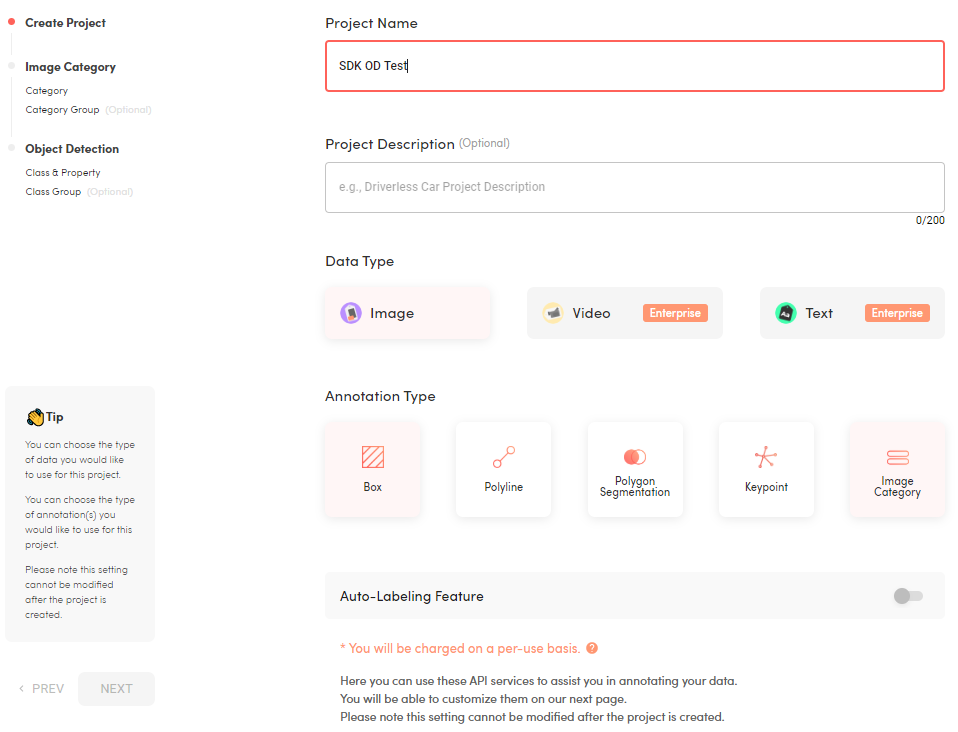

### Image Category

Add `bugatti`, `cleaner`, `gpu`, `sadcat`, `spiderman` (required), `butterflyknife`, `fidgetspinner`, `garfield`, `ted`, `teslaroadster`, `vr`, `yeezy` (optional).

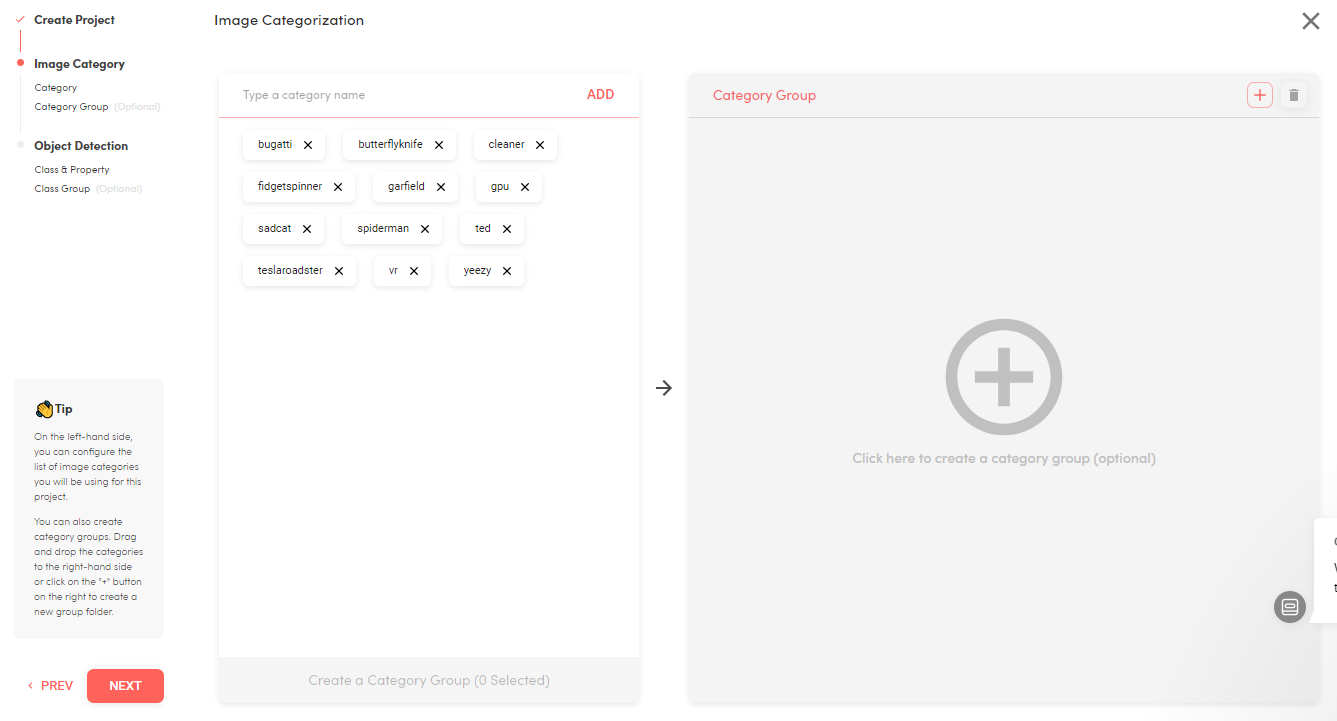

### Object Class

Add the same classes of `Box` objects.
Finish project creation without any more changes.

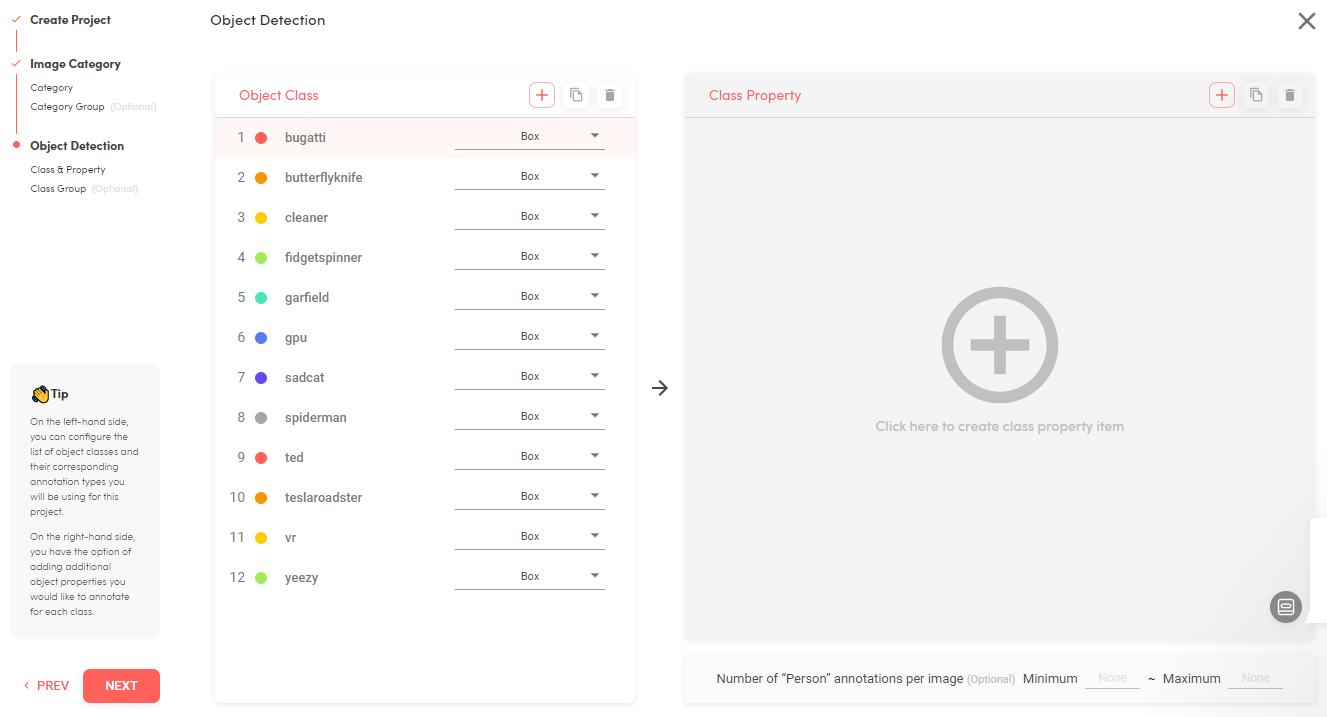

## Prepare Requirements

In [1]:
import init
import os, sys, logging
import cv2

sys.path.insert(0, 'lib')
from configs.faster.default_configs import config, update_config
import numpy as np

# get config
os.environ['PYTHONUNBUFFERED'] = '1'
os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '0'
os.environ['MXNET_ENABLE_GPU_P2P'] = '0'
update_config('./configs/faster/res101_mx_3k.yml')

# for Superb AI Suite SDK
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'

import mxnet as mx

from demo.tictoc import tic, toc

/SNIPER/configs/faster/default_configs.py:169: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


## Prepare Superb AI Suite SDK

### Initialize SDK

To find your access key, open context menu by clicking your name at the upper-right corner of Suite.
Then click `Advanced` in the context menu.

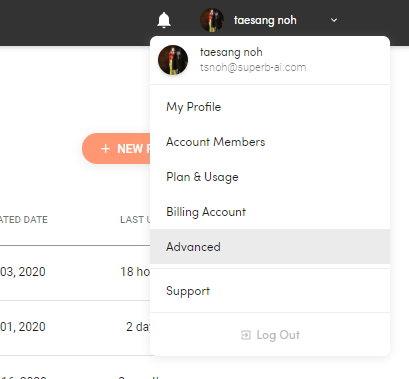

Click `Copy` button to copy your access key to clipboard.

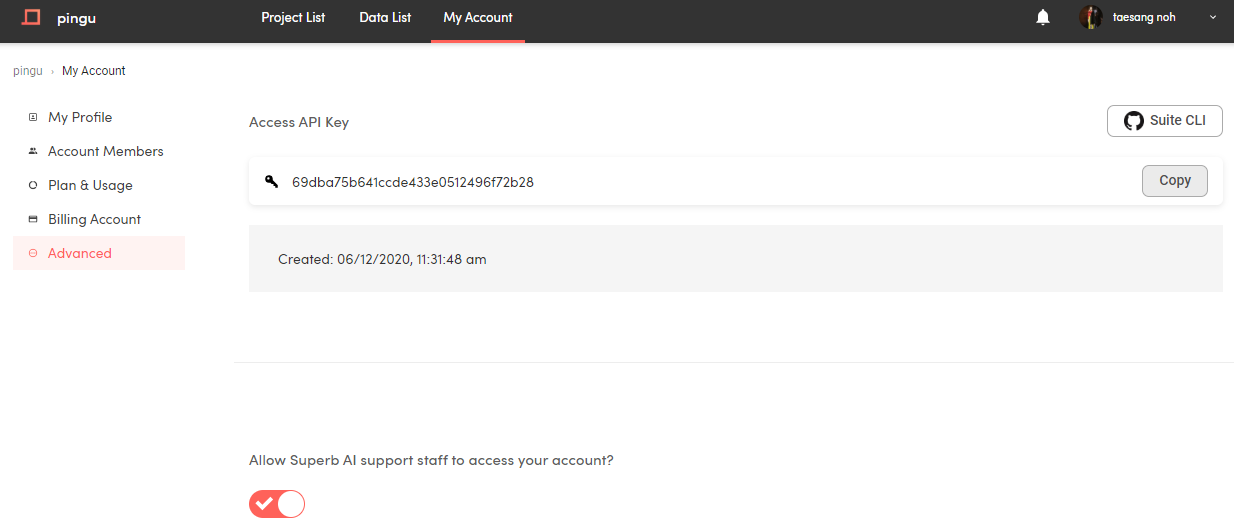

Your account name is the name you used for login Suite.
You can also find your account name at the upper-left corner of Suite.
Once you find your account name and account key, modify below line as "`your account name`\n`your account key`\n"

In [2]:
# modify below line as "your account name>\n<your account key>\n"
!printf "pingu\n69dba75b641ccde433e0512496f72b28\n" | spb configure

import spb
print(spb.__version__)

Suite Account Name: Access Key: Profile default is counfigured with account name 'pingu'.
0.0.34


### Get Handler of Project at Superb AI Suite

In [3]:
def get_spb_project(project_name):
    command = spb.Command(type='describe_project')

    projects, num_of_projects = spb.run(command=command, option={'name': project_name}, page=1, page_size=1)

    if num_of_projects == 0:
        raise Exception('Project {} not found'.format(project_name))
    assert num_of_projects == 1

    project = projects[0]
    print('Project ID: {}'.format(project.id))
    print('Project Name: {}'.format(project.name))
    return project

project = get_spb_project('SDK OD Test')

Project ID: 1ace2624-3395-433b-a67f-7a6a7b5de064
Project Name: SDK OD Test


## Upload Your Images to Superb AI Suite

### Get List of Your Images at Local Container

We prepared some images of 12 classes in your docker container: `bugatti`, `cleaner`, `gpu`, `sadcat`, `spiderman`, `butterflyknife`, `fidgetspinner`, `garfield`, `ted`, `teslaroadster`, `vr`, `yeezy`.
For each class, there are about 100 images.
You can freely choose any subset among those classes.

In [4]:
def get_image_list(image_root, class_names):
    files = []
    for idx, c in enumerate(class_names):
        files_c = [os.path.join(image_root, c, f) for f in os.listdir(os.path.join(image_root, c))
                   if os.path.isfile(os.path.join(image_root, c, f)) and f.split('.')[-1] in ['jpg', 'png']]
        files.append(files_c)
    return files

# choose any subset among `bugatti`, `cleaner`, `gpu`, `sadcat`, `spiderman`,
# `butterflyknife`, `fidgetspinner`, `garfield`, `ted`, `teslaroadster`, `vr`, `yeezy`
class_names = ['bugatti', 'cleaner', 'gpu', 'sadcat', 'spiderman']
image_root = './demo/image'

files = get_image_list(image_root, class_names)

print(', '.join(['{}: {} files'.format(name, len(files_c)) for name, files_c in zip(class_names, files)]))

bugatti: 115 files, cleaner: 111 files, gpu: 116 files, sadcat: 95 files, spiderman: 106 files


### Split Your Images into Train-Set and Val-Set

In [5]:
def random_split_into_train_val(files, num_val_per_class):
    train_files = []
    val_files = []

    for files_c in files:
        assert num_val_per_class < len(files_c)

        indices = list(range(len(files_c)))
        np.random.shuffle(indices)
        indices = indices[:num_val_per_class]
        indices.sort()

        for idx, f in enumerate(files_c):
            if idx in indices:
                val_files.append(f)
            else:
                train_files.append(f)

    return train_files, val_files

num_val_per_class = 50

train_files, val_files = random_split_into_train_val(files, num_val_per_class)

print('{} train files, {} val files'.format(len(train_files), len(val_files)))

293 train files, 250 val files


### Upload Images to Superb AI Suite

In [6]:
def upload_images_to_spb(project, dataset_name, files):
    command = spb.Command(type='create_data')

    for idx, f in enumerate(files):
        name = f.split('/')[-1]
        key = dataset_name + '_' + name
        option = {'file': f, 'file_name': name, 'dataset': dataset_name, 'data_key': key}

        try:
            spb.run(command=command, optional={'projectId': project.id}, option=option)
            print('Upload {}/{}: {} -> {}'.format(idx + 1, len(files), f, key))
        except Exception as e:
            print('[Exception {}] Upload {}/{}: {} -> {}'.format(str(e), idx + 1, len(files), f, key))

    print('Done')

spb_train_name = 'train_' + project.name.replace(' ', '_')
spb_val_name = 'val_' + project.name.replace(' ', '_')

upload_images_to_spb(project, spb_train_name, train_files)
upload_images_to_spb(project, spb_val_name, val_files)

Upload 1/293: ./demo/image/bugatti/bugatti_78.jpg -> train_SDK_OD_Test_bugatti_78.jpg
Upload 2/293: ./demo/image/bugatti/bugatti_84.jpg -> train_SDK_OD_Test_bugatti_84.jpg
Upload 3/293: ./demo/image/bugatti/bugatti_18.jpg -> train_SDK_OD_Test_bugatti_18.jpg
Upload 4/293: ./demo/image/bugatti/bugatti_29.jpg -> train_SDK_OD_Test_bugatti_29.jpg
Upload 5/293: ./demo/image/bugatti/bugatti_96.jpg -> train_SDK_OD_Test_bugatti_96.jpg
Upload 6/293: ./demo/image/bugatti/bugatti_98.jpg -> train_SDK_OD_Test_bugatti_98.jpg
Upload 7/293: ./demo/image/bugatti/bugatti_111.jpg -> train_SDK_OD_Test_bugatti_111.jpg
Upload 8/293: ./demo/image/bugatti/bugatti_83.jpg -> train_SDK_OD_Test_bugatti_83.jpg
Upload 9/293: ./demo/image/bugatti/bugatti_16.jpg -> train_SDK_OD_Test_bugatti_16.jpg
Upload 10/293: ./demo/image/bugatti/bugatti_46.jpg -> train_SDK_OD_Test_bugatti_46.jpg
Upload 11/293: ./demo/image/bugatti/bugatti_12.jpg -> train_SDK_OD_Test_bugatti_12.jpg
Upload 12/293: ./demo/image/bugatti/bugatti_40.jpg

Upload 96/293: ./demo/image/cleaner/cleaner_19.jpg -> train_SDK_OD_Test_cleaner_19.jpg
Upload 97/293: ./demo/image/cleaner/cleaner_104.jpg -> train_SDK_OD_Test_cleaner_104.jpg
Upload 98/293: ./demo/image/cleaner/cleaner_88.jpg -> train_SDK_OD_Test_cleaner_88.jpg
Upload 99/293: ./demo/image/cleaner/cleaner_61.jpg -> train_SDK_OD_Test_cleaner_61.jpg
Upload 100/293: ./demo/image/cleaner/cleaner_85.jpg -> train_SDK_OD_Test_cleaner_85.jpg
Upload 101/293: ./demo/image/cleaner/cleaner_9.jpg -> train_SDK_OD_Test_cleaner_9.jpg
Upload 102/293: ./demo/image/cleaner/cleaner_63.jpg -> train_SDK_OD_Test_cleaner_63.jpg
Upload 103/293: ./demo/image/cleaner/cleaner_93.jpg -> train_SDK_OD_Test_cleaner_93.jpg
Upload 104/293: ./demo/image/cleaner/cleaner_106.jpg -> train_SDK_OD_Test_cleaner_106.jpg
Upload 105/293: ./demo/image/cleaner/cleaner_80.jpg -> train_SDK_OD_Test_cleaner_80.jpg
Upload 106/293: ./demo/image/cleaner/cleaner_28.jpg -> train_SDK_OD_Test_cleaner_28.jpg
Upload 107/293: ./demo/image/clean

Upload 199/293: ./demo/image/sadcat/sadcat_16.jpg -> train_SDK_OD_Test_sadcat_16.jpg
Upload 200/293: ./demo/image/sadcat/sadcat_74.jpg -> train_SDK_OD_Test_sadcat_74.jpg
Upload 201/293: ./demo/image/sadcat/sadcat_71.jpg -> train_SDK_OD_Test_sadcat_71.jpg
Upload 202/293: ./demo/image/sadcat/sadcat_88.jpg -> train_SDK_OD_Test_sadcat_88.jpg
Upload 203/293: ./demo/image/sadcat/sadcat_99.jpg -> train_SDK_OD_Test_sadcat_99.jpg
Upload 204/293: ./demo/image/sadcat/sadcat_53.jpg -> train_SDK_OD_Test_sadcat_53.jpg
Upload 205/293: ./demo/image/sadcat/sadcat_27.jpg -> train_SDK_OD_Test_sadcat_27.jpg
Upload 206/293: ./demo/image/sadcat/sadcat_82.jpg -> train_SDK_OD_Test_sadcat_82.jpg
Upload 207/293: ./demo/image/sadcat/sadcat_14.jpg -> train_SDK_OD_Test_sadcat_14.jpg
Upload 208/293: ./demo/image/sadcat/sadcat_1.jpg -> train_SDK_OD_Test_sadcat_1.jpg
Upload 209/293: ./demo/image/sadcat/sadcat_32.jpg -> train_SDK_OD_Test_sadcat_32.jpg
Upload 210/293: ./demo/image/sadcat/sadcat_98.jpg -> train_SDK_OD_T

Upload 290/293: ./demo/image/spiderman/spiderman_42.jpg -> train_SDK_OD_Test_spiderman_42.jpg
Upload 291/293: ./demo/image/spiderman/spiderman_30.jpg -> train_SDK_OD_Test_spiderman_30.jpg
Upload 292/293: ./demo/image/spiderman/spiderman_95.jpg -> train_SDK_OD_Test_spiderman_95.jpg
Upload 293/293: ./demo/image/spiderman/spiderman_6.jpg -> train_SDK_OD_Test_spiderman_6.jpg
Done
Upload 1/250: ./demo/image/bugatti/bugatti_5.jpg -> val_SDK_OD_Test_bugatti_5.jpg
Upload 2/250: ./demo/image/bugatti/bugatti_3.jpg -> val_SDK_OD_Test_bugatti_3.jpg
Upload 3/250: ./demo/image/bugatti/bugatti_63.jpg -> val_SDK_OD_Test_bugatti_63.jpg
Upload 4/250: ./demo/image/bugatti/bugatti_1.jpg -> val_SDK_OD_Test_bugatti_1.jpg
Upload 5/250: ./demo/image/bugatti/bugatti_64.jpg -> val_SDK_OD_Test_bugatti_64.jpg
Upload 6/250: ./demo/image/bugatti/bugatti_32.jpg -> val_SDK_OD_Test_bugatti_32.jpg
Upload 7/250: ./demo/image/bugatti/bugatti_85.jpg -> val_SDK_OD_Test_bugatti_85.jpg
Upload 8/250: ./demo/image/bugatti/buga

Upload 94/250: ./demo/image/cleaner/cleaner_40.jpg -> val_SDK_OD_Test_cleaner_40.jpg
Upload 95/250: ./demo/image/cleaner/cleaner_18.jpg -> val_SDK_OD_Test_cleaner_18.jpg
Upload 96/250: ./demo/image/cleaner/cleaner_16.jpg -> val_SDK_OD_Test_cleaner_16.jpg
Upload 97/250: ./demo/image/cleaner/cleaner_58.jpg -> val_SDK_OD_Test_cleaner_58.jpg
Upload 98/250: ./demo/image/cleaner/cleaner_36.jpg -> val_SDK_OD_Test_cleaner_36.jpg
Upload 99/250: ./demo/image/cleaner/cleaner_67.jpg -> val_SDK_OD_Test_cleaner_67.jpg
Upload 100/250: ./demo/image/cleaner/cleaner_86.jpg -> val_SDK_OD_Test_cleaner_86.jpg
Upload 101/250: ./demo/image/gpu/gpu_43.jpg -> val_SDK_OD_Test_gpu_43.jpg
Upload 102/250: ./demo/image/gpu/gpu_20.jpg -> val_SDK_OD_Test_gpu_20.jpg
Upload 103/250: ./demo/image/gpu/gpu_44.jpg -> val_SDK_OD_Test_gpu_44.jpg
Upload 104/250: ./demo/image/gpu/gpu_17.jpg -> val_SDK_OD_Test_gpu_17.jpg
Upload 105/250: ./demo/image/gpu/gpu_16.jpg -> val_SDK_OD_Test_gpu_16.jpg
Upload 106/250: ./demo/image/gpu/g

Upload 198/250: ./demo/image/sadcat/sadcat_7.jpg -> val_SDK_OD_Test_sadcat_7.jpg
Upload 199/250: ./demo/image/sadcat/sadcat_95.jpg -> val_SDK_OD_Test_sadcat_95.jpg
Upload 200/250: ./demo/image/sadcat/sadcat_80.jpg -> val_SDK_OD_Test_sadcat_80.jpg
Upload 201/250: ./demo/image/spiderman/spiderman_71.jpg -> val_SDK_OD_Test_spiderman_71.jpg
Upload 202/250: ./demo/image/spiderman/spiderman_9.jpg -> val_SDK_OD_Test_spiderman_9.jpg
Upload 203/250: ./demo/image/spiderman/spiderman_44.jpg -> val_SDK_OD_Test_spiderman_44.jpg
Upload 204/250: ./demo/image/spiderman/spiderman_103.jpg -> val_SDK_OD_Test_spiderman_103.jpg
Upload 205/250: ./demo/image/spiderman/spiderman_86.jpg -> val_SDK_OD_Test_spiderman_86.jpg
Upload 206/250: ./demo/image/spiderman/spiderman_53.jpg -> val_SDK_OD_Test_spiderman_53.jpg
Upload 207/250: ./demo/image/spiderman/spiderman_100.jpg -> val_SDK_OD_Test_spiderman_100.jpg
Upload 208/250: ./demo/image/spiderman/spiderman_99.jpg -> val_SDK_OD_Test_spiderman_99.jpg
Upload 209/250:

## Weakly-Annotate Your Uploaded Images with Image-Level Classes

### Get Handler of Uploaded Images

In [7]:
def get_spb_data(project):
    command = spb.Command(type='describe_label')
    option = {'project_id': project.id}
    page_size = 10

    try:
        data, num_data = spb.run(command=command, option=option, page=1, page_size=page_size)
        num_pages = int(np.ceil(float(num_data) / page_size))
        print('Load page {}/{}'.format(1, num_pages))
    except Excetion as e:
        print('[Exception {}] Load page {}'.format(str(e), 1))
        return []

    for idx in range(1, num_pages):
        try:
            data_pg, _ = spb.run(command=command, option=option, page=idx+1, page_size=page_size)
            data = data + data_pg
            print('Load page {}/{}'.format(idx + 1, num_pages))
        except Excetion as e:
            print('[Exception {}] Load page {}/{}'.format(str(e), idx + 1, num_pages))

    print('Done')
    return data

spb_data = get_spb_data(project)

Load page 1/55
Load page 2/55
Load page 3/55
Load page 4/55
Load page 5/55
Load page 6/55
Load page 7/55
Load page 8/55
Load page 9/55
Load page 10/55
Load page 11/55
Load page 12/55
Load page 13/55
Load page 14/55
Load page 15/55
Load page 16/55
Load page 17/55
Load page 18/55
Load page 19/55
Load page 20/55
Load page 21/55
Load page 22/55
Load page 23/55
Load page 24/55
Load page 25/55
Load page 26/55
Load page 27/55
Load page 28/55
Load page 29/55
Load page 30/55
Load page 31/55
Load page 32/55
Load page 33/55
Load page 34/55
Load page 35/55
Load page 36/55
Load page 37/55
Load page 38/55
Load page 39/55
Load page 40/55
Load page 41/55
Load page 42/55
Load page 43/55
Load page 44/55
Load page 45/55
Load page 46/55
Load page 47/55
Load page 48/55
Load page 49/55
Load page 50/55
Load page 51/55
Load page 52/55
Load page 53/55
Load page 54/55
Load page 55/55
Done


### Label Image-Level Classes of Uploaded Images

In [8]:
def annotate_image_category(project, spb_data):
    command = spb.Command(type='update_label')
    class_name_to_spb_id = {c['name']: c['id']
                            for c in project.label_interface['categorization']['word_map'] if c['id'] != 'root'}

    for idx, d in enumerate(spb_data):
        class_name = d.data_key.split('_')[-2]
        d.result = {'objects': [], 'categorization': {'value': [class_name_to_spb_id[class_name]]}}

        try:
            d = spb.run(command=command, option=d)
            print('Annotate {}/{}: {} -> {}'.format(idx + 1, len(spb_data), class_name, d.data_key))
        except Exception as e:
            print('[Exception {}] Annotate {}/{}: {} -> {}'.format(str(e), idx + 1, len(spb_data), class_name, d.data_key))

    print('Done')

annotate_image_category(project, spb_data)

Annotate 1/542: bugatti -> train_SDK_OD_Test_bugatti_78.jpg
Annotate 2/542: bugatti -> train_SDK_OD_Test_bugatti_84.jpg
Annotate 3/542: bugatti -> train_SDK_OD_Test_bugatti_18.jpg
Annotate 4/542: bugatti -> train_SDK_OD_Test_bugatti_29.jpg
Annotate 5/542: bugatti -> train_SDK_OD_Test_bugatti_96.jpg
Annotate 6/542: bugatti -> train_SDK_OD_Test_bugatti_98.jpg
Annotate 7/542: bugatti -> train_SDK_OD_Test_bugatti_111.jpg
Annotate 8/542: bugatti -> train_SDK_OD_Test_bugatti_83.jpg
Annotate 9/542: bugatti -> train_SDK_OD_Test_bugatti_16.jpg
Annotate 10/542: bugatti -> train_SDK_OD_Test_bugatti_46.jpg
Annotate 11/542: bugatti -> train_SDK_OD_Test_bugatti_12.jpg
Annotate 12/542: bugatti -> train_SDK_OD_Test_bugatti_40.jpg
Annotate 13/542: bugatti -> train_SDK_OD_Test_bugatti_30.jpg
Annotate 14/542: bugatti -> train_SDK_OD_Test_bugatti_67.jpg
Annotate 15/542: bugatti -> train_SDK_OD_Test_bugatti_62.jpg
Annotate 16/542: bugatti -> train_SDK_OD_Test_bugatti_41.jpg
Annotate 17/542: bugatti -> trai

Annotate 136/542: gpu -> train_SDK_OD_Test_gpu_84.jpg
Annotate 137/542: gpu -> train_SDK_OD_Test_gpu_65.jpg
Annotate 138/542: gpu -> train_SDK_OD_Test_gpu_19.jpg
Annotate 139/542: gpu -> train_SDK_OD_Test_gpu_24.jpg
Annotate 140/542: gpu -> train_SDK_OD_Test_gpu_69.jpg
Annotate 141/542: gpu -> train_SDK_OD_Test_gpu_48.jpg
Annotate 142/542: gpu -> train_SDK_OD_Test_gpu_9.jpg
Annotate 143/542: gpu -> train_SDK_OD_Test_gpu_86.jpg
Annotate 144/542: gpu -> train_SDK_OD_Test_gpu_68.jpg
Annotate 145/542: gpu -> train_SDK_OD_Test_gpu_89.jpg
Annotate 146/542: gpu -> train_SDK_OD_Test_gpu_109.jpg
Annotate 147/542: gpu -> train_SDK_OD_Test_gpu_106.jpg
Annotate 148/542: gpu -> train_SDK_OD_Test_gpu_88.jpg
Annotate 149/542: gpu -> train_SDK_OD_Test_gpu_34.jpg
Annotate 150/542: gpu -> train_SDK_OD_Test_gpu_52.jpg
Annotate 151/542: gpu -> train_SDK_OD_Test_gpu_42.jpg
Annotate 152/542: gpu -> train_SDK_OD_Test_gpu_54.jpg
Annotate 153/542: gpu -> train_SDK_OD_Test_gpu_62.jpg
Annotate 154/542: gpu -> tr

Annotate 275/542: spiderman -> train_SDK_OD_Test_spiderman_37.jpg
Annotate 276/542: spiderman -> train_SDK_OD_Test_spiderman_79.jpg
Annotate 277/542: spiderman -> train_SDK_OD_Test_spiderman_47.jpg
Annotate 278/542: spiderman -> train_SDK_OD_Test_spiderman_13.jpg
Annotate 279/542: spiderman -> train_SDK_OD_Test_spiderman_74.jpg
Annotate 280/542: spiderman -> train_SDK_OD_Test_spiderman_1.jpg
Annotate 281/542: spiderman -> train_SDK_OD_Test_spiderman_90.jpg
Annotate 282/542: spiderman -> train_SDK_OD_Test_spiderman_35.jpg
Annotate 283/542: spiderman -> train_SDK_OD_Test_spiderman_82.jpg
Annotate 284/542: spiderman -> train_SDK_OD_Test_spiderman_59.jpg
Annotate 285/542: spiderman -> train_SDK_OD_Test_spiderman_12.jpg
Annotate 286/542: spiderman -> train_SDK_OD_Test_spiderman_39.jpg
Annotate 287/542: spiderman -> train_SDK_OD_Test_spiderman_21.jpg
Annotate 288/542: spiderman -> train_SDK_OD_Test_spiderman_32.jpg
Annotate 289/542: spiderman -> train_SDK_OD_Test_spiderman_42.jpg
Annotate 29

Annotate 413/542: gpu -> val_SDK_OD_Test_gpu_97.jpg
Annotate 414/542: gpu -> val_SDK_OD_Test_gpu_76.jpg
Annotate 415/542: gpu -> val_SDK_OD_Test_gpu_35.jpg
Annotate 416/542: gpu -> val_SDK_OD_Test_gpu_53.jpg
Annotate 417/542: gpu -> val_SDK_OD_Test_gpu_55.jpg
Annotate 418/542: gpu -> val_SDK_OD_Test_gpu_73.jpg
Annotate 419/542: gpu -> val_SDK_OD_Test_gpu_66.jpg
Annotate 420/542: gpu -> val_SDK_OD_Test_gpu_15.jpg
Annotate 421/542: gpu -> val_SDK_OD_Test_gpu_102.jpg
Annotate 422/542: gpu -> val_SDK_OD_Test_gpu_75.jpg
Annotate 423/542: gpu -> val_SDK_OD_Test_gpu_39.jpg
Annotate 424/542: gpu -> val_SDK_OD_Test_gpu_61.jpg
Annotate 425/542: gpu -> val_SDK_OD_Test_gpu_36.jpg
Annotate 426/542: gpu -> val_SDK_OD_Test_gpu_101.jpg
Annotate 427/542: gpu -> val_SDK_OD_Test_gpu_31.jpg
Annotate 428/542: gpu -> val_SDK_OD_Test_gpu_57.jpg
Annotate 429/542: gpu -> val_SDK_OD_Test_gpu_6.jpg
Annotate 430/542: gpu -> val_SDK_OD_Test_gpu_93.jpg
Annotate 431/542: gpu -> val_SDK_OD_Test_gpu_116.jpg
Annotate 4

## Few-Shot Train Object Detector using Weakly-Labeled Data

### Load Images and Weak-Labels from Superb AI Suite

In [9]:
import skimage.io
from demo.image import resize, transform

def load_and_transform_spb_images(project, spb_data, class_names):
    images = []
    im_infos = []
    mx_data = []
    labels = []
    ref_spb_data = []

    class_spb_id_to_name = {c['id']: c['name']
                            for c in project.label_interface['categorization']['word_map'] if c['id'] != 'root'}
    class_name_to_label = {name: idx for idx, name in enumerate(class_names)}

    print('Load and transform images...')
    tic()

    for idx, d in enumerate(spb_data):
        try:
            im = skimage.io.imread(d.data_url)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            class_spb_id = d.result['categorization']['value'][0]
            class_name = class_spb_id_to_name[class_spb_id]
            label = class_name_to_label[class_name]

        except Exception as e:
            print('[Exception {}] Load and transform {}'.format(str(e), d.data_key))
            continue

        target_size = config.TEST.SCALES[0][0]
        max_size = config.TEST.SCALES[0][1]

        im, im_scale = resize(im, target_size, max_size, stride=config.network.RPN_FEAT_STRIDE)
        im_tensor = transform(im, config.network.PIXEL_MEANS)
        im_info = np.array([[im_tensor.shape[2], im_tensor.shape[3], im_scale]], dtype=np.float32)

        images.append(im)
        im_infos.append(im_info)
        mx_data.append([mx.nd.array(im_tensor), mx.nd.array(im_info)])
        labels.append(label)
        ref_spb_data.append(d)

        if (idx + 1) % 100 == 0:
            print('Load and transform {}/{}: {:.4f} seconds spent.'.format(idx + 1, len(spb_data), toc()))

    print('Done')
    return images, im_infos, mx_data, labels, ref_spb_data

images, im_infos, mx_data, labels, ref_spb_data = load_and_transform_spb_images(project, spb_data, class_names)

Load and transform images...
Load and transform 100/542: 15.7070 seconds spent.
Load and transform 200/542: 30.3310 seconds spent.
Load and transform 300/542: 43.7993 seconds spent.
Load and transform 400/542: 59.7905 seconds spent.
Load and transform 500/542: 72.7542 seconds spent.
Done


### Build Object Detector with Linear Classification Head

In [10]:
# build pre-trained R-FCN-3000 object detector that produces
# 1) feature map of image
# 2) class-agnostic RoIs in image
# 3) objectness scores of RoIs

from demo.module import MutableModule
from demo.load_model import load_param
from symbols.faster.resnet_mx_101_e2e_3k_demo import resnet_mx_101_e2e_3k_demo

def build_feat_extractor(config, arch, ckpt, dummy_mx_data):
    # calculate maximum input size
    max_im_h = max([v[0] for v in config.TEST.SCALES])
    max_im_w = max([v[1] for v in config.TEST.SCALES])
    max_data_shape = [('data', (1, 3, max_im_h, max_im_w))]

    # build architecture
    feat_extractor = MutableModule(arch.get_symbol_rcnn(config, is_train=False),
                                   data_names=['data', 'im_info'], label_names=[],
                                   context=[mx.gpu(0)],
                                   max_data_shapes=[max_data_shape])

    # initialize parameters
    feat_extractor.bind([[('data', dummy_mx_data[0].shape), ('im_info', dummy_mx_data[1].shape)]],
                        [None], for_training=False)

    # load pre-trained weights
    arg_params, aux_params = load_param(ckpt, config.TEST.TEST_EPOCH, convert=True, process=True)
    feat_extractor.init_params(arg_params=arg_params, aux_params=aux_params)

    return feat_extractor

feat_extractor_arch = resnet_mx_101_e2e_3k_demo()
feat_extractor_ckpt = './output/chips_resnet101_3k/res101_mx_3k/fall11_whole/CRCNN'

feat_extractor = build_feat_extractor(config, feat_extractor_arch, feat_extractor_ckpt, mx_data[0])

In [11]:
# build linear classifier that will be trained with few-shot weakly-labeled data
# to predict class scores for images or RoIs

def build_linear_classifier(logger, num_of_classes):
    x = mx.sym.Variable('data')
    y = mx.sym.Variable("softmax_label")
    logit = mx.sym.FullyConnected(data=x, name='fc1', num_hidden=num_of_classes)
    softmax = mx.sym.SoftmaxOutput(data=logit, label=y, name='softmax')

    model = mx.mod.Module(symbol=softmax, data_names=['data'], label_names=['softmax_label'],
                          logger=logger, context=mx.gpu())
    return model

logger = logging.getLogger()
logger.setLevel(logging.INFO)

linear_classifier = build_linear_classifier(logger, len(class_names))

### Prepare Train-Set and Val-Set

In [12]:
# extract features of weakly-labeled images

def extract_im_feats(feat_extractor, mx_data):
    im_feats = []

    print("Extract image-level features...")
    tic()

    for idx, d in enumerate(mx_data):
        # batch of size 1
        x = mx.io.DataBatch(data=[d], label=[], pad=0, index=idx,
                            provide_data=[[('data', d[0].shape), ('im_info', d[1].shape)]],
                            provide_label=[None])

        # global average pooling of conv feature
        feat_extractor.forward(x)
        conv5_feat = feat_extractor.get_outputs()[4]
        pooled_feat = mx.ndarray.Pooling(data=conv5_feat, pool_type='avg', global_pool=True, kernel=(7, 7))
        im_feats.append(pooled_feat.reshape((1, -1)).asnumpy())

        if (idx + 1) % 100 == 0:
            print('Image-level feature extraction {}/{}: {:.4f} seconds spent.'.format(idx + 1, len(mx_data), toc()))

    print('Done')
    return im_feats

im_feats = extract_im_feats(feat_extractor, mx_data)

Extract image-level features...
Image-level feature extraction 100/542: 5.2513 seconds spent.
Image-level feature extraction 200/542: 10.2650 seconds spent.
Image-level feature extraction 300/542: 15.4543 seconds spent.
Image-level feature extraction 400/542: 20.8401 seconds spent.
Image-level feature extraction 500/542: 25.7501 seconds spent.
Done


In [13]:
# split weakly-labeled images into train-set and val-set

def split_train_val(elems, spb_data, spb_train_name, spb_val_name):
    train_elems = [elem for elem, d in zip(elems, spb_data) if d.dataset == spb_train_name]
    val_elems = [elem for elem, d in zip(elems, spb_data) if d.dataset == spb_val_name]
    return train_elems, val_elems

train_im_feats, val_im_feats = split_train_val(im_feats, spb_data, spb_train_name, spb_val_name)
train_labels, val_labels = split_train_val(labels, spb_data, spb_train_name, spb_val_name)

### Few-Shot Train Linear Classification Head

In [14]:
# training takes only a few seconds

def train_linear_classifier(linear_classifier, train_im_feats, train_labels, val_im_feats, val_labels,
                           batch_size, learning_rate, momentum, num_epoch):

    train_iterator = mx.io.NDArrayIter(np.concatenate(train_im_feats),
                                       np.array(train_labels),
                                       batch_size, shuffle=True)

    val_iterator = mx.io.NDArrayIter(np.concatenate(val_im_feats),
                                       np.array(val_labels),
                                       batch_size, shuffle=False)

    linear_classifier.fit(train_iterator, val_iterator, optimizer='sgd',
                          optimizer_params={'learning_rate':learning_rate, 'momentum': momentum},
                          num_epoch=num_epoch, eval_metric='acc',
                          batch_end_callback = mx.callback.Speedometer(batch_size, 2))

batch_size = 30
learning_rate = 0.001
momentum = 0.9
num_epoch = 250

train_linear_classifier(linear_classifier, train_im_feats, train_labels, val_im_feats, val_labels,
                       batch_size, learning_rate, momentum, num_epoch)

INFO:root:Epoch[0] Batch [2]	Speed: 31679.03 samples/sec	accuracy=0.400000
INFO:root:Epoch[0] Batch [4]	Speed: 28257.16 samples/sec	accuracy=0.683333
INFO:root:Epoch[0] Batch [6]	Speed: 30397.18 samples/sec	accuracy=0.800000
INFO:root:Epoch[0] Batch [8]	Speed: 20068.44 samples/sec	accuracy=0.900000
INFO:root:Epoch[0] Train-accuracy=0.933333
INFO:root:Epoch[0] Time cost=0.017
INFO:root:Epoch[0] Validation-accuracy=0.940741
INFO:root:Epoch[1] Batch [2]	Speed: 28571.55 samples/sec	accuracy=0.988889
INFO:root:Epoch[1] Batch [4]	Speed: 23937.81 samples/sec	accuracy=0.966667
INFO:root:Epoch[1] Batch [6]	Speed: 24305.41 samples/sec	accuracy=0.933333
INFO:root:Epoch[1] Batch [8]	Speed: 20176.24 samples/sec	accuracy=0.966667
INFO:root:Epoch[1] Train-accuracy=1.000000
INFO:root:Epoch[1] Time cost=0.018
INFO:root:Epoch[1] Validation-accuracy=0.981481
INFO:root:Epoch[2] Batch [2]	Speed: 30708.75 samples/sec	accuracy=1.000000
INFO:root:Epoch[2] Batch [4]	Speed: 22272.61 samples/sec	accuracy=0.98333

INFO:root:Epoch[19] Batch [4]	Speed: 20030.11 samples/sec	accuracy=1.000000
INFO:root:Epoch[19] Batch [6]	Speed: 21140.65 samples/sec	accuracy=0.983333
INFO:root:Epoch[19] Batch [8]	Speed: 17522.51 samples/sec	accuracy=0.983333
INFO:root:Epoch[19] Train-accuracy=1.000000
INFO:root:Epoch[19] Time cost=0.020
INFO:root:Epoch[19] Validation-accuracy=0.992593
INFO:root:Epoch[20] Batch [2]	Speed: 30504.03 samples/sec	accuracy=1.000000
INFO:root:Epoch[20] Batch [4]	Speed: 20350.82 samples/sec	accuracy=1.000000
INFO:root:Epoch[20] Batch [6]	Speed: 23545.87 samples/sec	accuracy=0.983333
INFO:root:Epoch[20] Batch [8]	Speed: 17080.10 samples/sec	accuracy=0.983333
INFO:root:Epoch[20] Train-accuracy=1.000000
INFO:root:Epoch[20] Time cost=0.020
INFO:root:Epoch[20] Validation-accuracy=0.992593
INFO:root:Epoch[21] Batch [2]	Speed: 27524.69 samples/sec	accuracy=1.000000
INFO:root:Epoch[21] Batch [4]	Speed: 20423.49 samples/sec	accuracy=1.000000
INFO:root:Epoch[21] Batch [6]	Speed: 22525.80 samples/sec	

INFO:root:Epoch[38] Batch [4]	Speed: 21149.53 samples/sec	accuracy=1.000000
INFO:root:Epoch[38] Batch [6]	Speed: 21240.57 samples/sec	accuracy=0.983333
INFO:root:Epoch[38] Batch [8]	Speed: 17362.93 samples/sec	accuracy=0.983333
INFO:root:Epoch[38] Train-accuracy=1.000000
INFO:root:Epoch[38] Time cost=0.020
INFO:root:Epoch[38] Validation-accuracy=0.992593
INFO:root:Epoch[39] Batch [2]	Speed: 28600.78 samples/sec	accuracy=1.000000
INFO:root:Epoch[39] Batch [4]	Speed: 20314.68 samples/sec	accuracy=1.000000
INFO:root:Epoch[39] Batch [6]	Speed: 21616.41 samples/sec	accuracy=0.983333
INFO:root:Epoch[39] Batch [8]	Speed: 16339.32 samples/sec	accuracy=0.983333
INFO:root:Epoch[39] Train-accuracy=1.000000
INFO:root:Epoch[39] Time cost=0.020
INFO:root:Epoch[39] Validation-accuracy=0.996296
INFO:root:Epoch[40] Batch [2]	Speed: 27446.64 samples/sec	accuracy=1.000000
INFO:root:Epoch[40] Batch [4]	Speed: 21233.40 samples/sec	accuracy=1.000000
INFO:root:Epoch[40] Batch [6]	Speed: 21496.39 samples/sec	

INFO:root:Epoch[57] Batch [4]	Speed: 21679.72 samples/sec	accuracy=1.000000
INFO:root:Epoch[57] Batch [6]	Speed: 21629.41 samples/sec	accuracy=1.000000
INFO:root:Epoch[57] Batch [8]	Speed: 17036.17 samples/sec	accuracy=1.000000
INFO:root:Epoch[57] Train-accuracy=1.000000
INFO:root:Epoch[57] Time cost=0.020
INFO:root:Epoch[57] Validation-accuracy=0.996296
INFO:root:Epoch[58] Batch [2]	Speed: 28071.19 samples/sec	accuracy=1.000000
INFO:root:Epoch[58] Batch [4]	Speed: 20685.37 samples/sec	accuracy=1.000000
INFO:root:Epoch[58] Batch [6]	Speed: 21542.39 samples/sec	accuracy=1.000000
INFO:root:Epoch[58] Batch [8]	Speed: 16595.77 samples/sec	accuracy=1.000000
INFO:root:Epoch[58] Train-accuracy=1.000000
INFO:root:Epoch[58] Time cost=0.021
INFO:root:Epoch[58] Validation-accuracy=0.996296
INFO:root:Epoch[59] Batch [2]	Speed: 27597.13 samples/sec	accuracy=1.000000
INFO:root:Epoch[59] Batch [4]	Speed: 19995.09 samples/sec	accuracy=1.000000
INFO:root:Epoch[59] Batch [6]	Speed: 21720.89 samples/sec	

INFO:root:Epoch[76] Batch [4]	Speed: 20171.39 samples/sec	accuracy=1.000000
INFO:root:Epoch[76] Batch [6]	Speed: 21640.57 samples/sec	accuracy=1.000000
INFO:root:Epoch[76] Batch [8]	Speed: 16504.34 samples/sec	accuracy=1.000000
INFO:root:Epoch[76] Train-accuracy=1.000000
INFO:root:Epoch[76] Time cost=0.021
INFO:root:Epoch[76] Validation-accuracy=0.996296
INFO:root:Epoch[77] Batch [2]	Speed: 26926.84 samples/sec	accuracy=1.000000
INFO:root:Epoch[77] Batch [4]	Speed: 21614.55 samples/sec	accuracy=1.000000
INFO:root:Epoch[77] Batch [6]	Speed: 20983.76 samples/sec	accuracy=1.000000
INFO:root:Epoch[77] Batch [8]	Speed: 18019.35 samples/sec	accuracy=1.000000
INFO:root:Epoch[77] Train-accuracy=1.000000
INFO:root:Epoch[77] Time cost=0.020
INFO:root:Epoch[77] Validation-accuracy=0.996296
INFO:root:Epoch[78] Batch [2]	Speed: 27866.04 samples/sec	accuracy=1.000000
INFO:root:Epoch[78] Batch [4]	Speed: 22023.12 samples/sec	accuracy=1.000000
INFO:root:Epoch[78] Batch [6]	Speed: 22865.55 samples/sec	

INFO:root:Epoch[95] Batch [4]	Speed: 20111.74 samples/sec	accuracy=1.000000
INFO:root:Epoch[95] Batch [6]	Speed: 20340.95 samples/sec	accuracy=1.000000
INFO:root:Epoch[95] Batch [8]	Speed: 16102.01 samples/sec	accuracy=1.000000
INFO:root:Epoch[95] Train-accuracy=1.000000
INFO:root:Epoch[95] Time cost=0.020
INFO:root:Epoch[95] Validation-accuracy=0.996296
INFO:root:Epoch[96] Batch [2]	Speed: 30641.45 samples/sec	accuracy=1.000000
INFO:root:Epoch[96] Batch [4]	Speed: 23104.87 samples/sec	accuracy=1.000000
INFO:root:Epoch[96] Batch [6]	Speed: 21841.54 samples/sec	accuracy=1.000000
INFO:root:Epoch[96] Batch [8]	Speed: 17587.41 samples/sec	accuracy=1.000000
INFO:root:Epoch[96] Train-accuracy=1.000000
INFO:root:Epoch[96] Time cost=0.019
INFO:root:Epoch[96] Validation-accuracy=0.996296
INFO:root:Epoch[97] Batch [2]	Speed: 30637.72 samples/sec	accuracy=1.000000
INFO:root:Epoch[97] Batch [4]	Speed: 21276.48 samples/sec	accuracy=1.000000
INFO:root:Epoch[97] Batch [6]	Speed: 22369.62 samples/sec	

INFO:root:Epoch[113] Validation-accuracy=0.996296
INFO:root:Epoch[114] Batch [2]	Speed: 19856.26 samples/sec	accuracy=1.000000
INFO:root:Epoch[114] Batch [4]	Speed: 17073.15 samples/sec	accuracy=1.000000
INFO:root:Epoch[114] Batch [6]	Speed: 18290.45 samples/sec	accuracy=1.000000
INFO:root:Epoch[114] Batch [8]	Speed: 14076.42 samples/sec	accuracy=1.000000
INFO:root:Epoch[114] Train-accuracy=1.000000
INFO:root:Epoch[114] Time cost=0.024
INFO:root:Epoch[114] Validation-accuracy=0.996296
INFO:root:Epoch[115] Batch [2]	Speed: 25880.12 samples/sec	accuracy=1.000000
INFO:root:Epoch[115] Batch [4]	Speed: 19162.28 samples/sec	accuracy=1.000000
INFO:root:Epoch[115] Batch [6]	Speed: 18696.75 samples/sec	accuracy=1.000000
INFO:root:Epoch[115] Batch [8]	Speed: 14663.69 samples/sec	accuracy=1.000000
INFO:root:Epoch[115] Train-accuracy=1.000000
INFO:root:Epoch[115] Time cost=0.023
INFO:root:Epoch[115] Validation-accuracy=0.996296
INFO:root:Epoch[116] Batch [2]	Speed: 28548.86 samples/sec	accuracy=1.

INFO:root:Epoch[132] Batch [8]	Speed: 17444.77 samples/sec	accuracy=1.000000
INFO:root:Epoch[132] Train-accuracy=1.000000
INFO:root:Epoch[132] Time cost=0.020
INFO:root:Epoch[132] Validation-accuracy=0.996296
INFO:root:Epoch[133] Batch [2]	Speed: 31843.38 samples/sec	accuracy=1.000000
INFO:root:Epoch[133] Batch [4]	Speed: 22572.27 samples/sec	accuracy=1.000000
INFO:root:Epoch[133] Batch [6]	Speed: 25621.89 samples/sec	accuracy=1.000000
INFO:root:Epoch[133] Batch [8]	Speed: 20556.95 samples/sec	accuracy=1.000000
INFO:root:Epoch[133] Train-accuracy=1.000000
INFO:root:Epoch[133] Time cost=0.019
INFO:root:Epoch[133] Validation-accuracy=0.996296
INFO:root:Epoch[134] Batch [2]	Speed: 30518.83 samples/sec	accuracy=1.000000
INFO:root:Epoch[134] Batch [4]	Speed: 21634.99 samples/sec	accuracy=1.000000
INFO:root:Epoch[134] Batch [6]	Speed: 23583.38 samples/sec	accuracy=1.000000
INFO:root:Epoch[134] Batch [8]	Speed: 17360.53 samples/sec	accuracy=1.000000
INFO:root:Epoch[134] Train-accuracy=1.00000

INFO:root:Epoch[151] Batch [4]	Speed: 20049.25 samples/sec	accuracy=1.000000
INFO:root:Epoch[151] Batch [6]	Speed: 22395.50 samples/sec	accuracy=1.000000
INFO:root:Epoch[151] Batch [8]	Speed: 16892.08 samples/sec	accuracy=1.000000
INFO:root:Epoch[151] Train-accuracy=1.000000
INFO:root:Epoch[151] Time cost=0.021
INFO:root:Epoch[151] Validation-accuracy=0.996296
INFO:root:Epoch[152] Batch [2]	Speed: 28626.80 samples/sec	accuracy=1.000000
INFO:root:Epoch[152] Batch [4]	Speed: 22865.55 samples/sec	accuracy=1.000000
INFO:root:Epoch[152] Batch [6]	Speed: 22349.75 samples/sec	accuracy=1.000000
INFO:root:Epoch[152] Batch [8]	Speed: 17025.79 samples/sec	accuracy=1.000000
INFO:root:Epoch[152] Train-accuracy=1.000000
INFO:root:Epoch[152] Time cost=0.021
INFO:root:Epoch[152] Validation-accuracy=0.996296
INFO:root:Epoch[153] Batch [2]	Speed: 22574.29 samples/sec	accuracy=1.000000
INFO:root:Epoch[153] Batch [4]	Speed: 16801.86 samples/sec	accuracy=1.000000
INFO:root:Epoch[153] Batch [6]	Speed: 18804

INFO:root:Epoch[169] Time cost=0.022
INFO:root:Epoch[169] Validation-accuracy=0.996296
INFO:root:Epoch[170] Batch [2]	Speed: 24679.64 samples/sec	accuracy=1.000000
INFO:root:Epoch[170] Batch [4]	Speed: 21108.73 samples/sec	accuracy=1.000000
INFO:root:Epoch[170] Batch [6]	Speed: 21145.97 samples/sec	accuracy=1.000000
INFO:root:Epoch[170] Batch [8]	Speed: 16777.22 samples/sec	accuracy=1.000000
INFO:root:Epoch[170] Train-accuracy=1.000000
INFO:root:Epoch[170] Time cost=0.021
INFO:root:Epoch[170] Validation-accuracy=0.996296
INFO:root:Epoch[171] Batch [2]	Speed: 31607.42 samples/sec	accuracy=1.000000
INFO:root:Epoch[171] Batch [4]	Speed: 22367.63 samples/sec	accuracy=1.000000
INFO:root:Epoch[171] Batch [6]	Speed: 20405.27 samples/sec	accuracy=1.000000
INFO:root:Epoch[171] Batch [8]	Speed: 20680.27 samples/sec	accuracy=1.000000
INFO:root:Epoch[171] Train-accuracy=1.000000
INFO:root:Epoch[171] Time cost=0.020
INFO:root:Epoch[171] Validation-accuracy=0.996296
INFO:root:Epoch[172] Batch [2]	Sp

INFO:root:Epoch[188] Batch [8]	Speed: 14478.93 samples/sec	accuracy=1.000000
INFO:root:Epoch[188] Train-accuracy=1.000000
INFO:root:Epoch[188] Time cost=0.023
INFO:root:Epoch[188] Validation-accuracy=0.996296
INFO:root:Epoch[189] Batch [2]	Speed: 29358.17 samples/sec	accuracy=1.000000
INFO:root:Epoch[189] Batch [4]	Speed: 22537.90 samples/sec	accuracy=1.000000
INFO:root:Epoch[189] Batch [6]	Speed: 25183.45 samples/sec	accuracy=1.000000
INFO:root:Epoch[189] Batch [8]	Speed: 17562.86 samples/sec	accuracy=1.000000
INFO:root:Epoch[189] Train-accuracy=1.000000
INFO:root:Epoch[189] Time cost=0.022
INFO:root:Epoch[189] Validation-accuracy=0.996296
INFO:root:Epoch[190] Batch [2]	Speed: 25858.84 samples/sec	accuracy=1.000000
INFO:root:Epoch[190] Batch [4]	Speed: 20103.71 samples/sec	accuracy=1.000000
INFO:root:Epoch[190] Batch [6]	Speed: 23654.31 samples/sec	accuracy=1.000000
INFO:root:Epoch[190] Batch [8]	Speed: 17499.36 samples/sec	accuracy=1.000000
INFO:root:Epoch[190] Train-accuracy=1.00000

INFO:root:Epoch[207] Batch [4]	Speed: 22457.45 samples/sec	accuracy=1.000000
INFO:root:Epoch[207] Batch [6]	Speed: 19217.89 samples/sec	accuracy=1.000000
INFO:root:Epoch[207] Batch [8]	Speed: 17991.01 samples/sec	accuracy=1.000000
INFO:root:Epoch[207] Train-accuracy=1.000000
INFO:root:Epoch[207] Time cost=0.021
INFO:root:Epoch[207] Validation-accuracy=0.996296
INFO:root:Epoch[208] Batch [2]	Speed: 25640.17 samples/sec	accuracy=1.000000
INFO:root:Epoch[208] Batch [4]	Speed: 21008.28 samples/sec	accuracy=1.000000
INFO:root:Epoch[208] Batch [6]	Speed: 19927.01 samples/sec	accuracy=1.000000
INFO:root:Epoch[208] Batch [8]	Speed: 14212.36 samples/sec	accuracy=1.000000
INFO:root:Epoch[208] Train-accuracy=1.000000
INFO:root:Epoch[208] Time cost=0.023
INFO:root:Epoch[208] Validation-accuracy=0.996296
INFO:root:Epoch[209] Batch [2]	Speed: 28899.66 samples/sec	accuracy=1.000000
INFO:root:Epoch[209] Batch [4]	Speed: 20334.38 samples/sec	accuracy=1.000000
INFO:root:Epoch[209] Batch [6]	Speed: 24013

INFO:root:Epoch[244] Batch [6]	Speed: 17087.06 samples/sec	accuracy=1.000000
INFO:root:Epoch[244] Batch [8]	Speed: 11785.62 samples/sec	accuracy=1.000000
INFO:root:Epoch[244] Train-accuracy=1.000000
INFO:root:Epoch[244] Time cost=0.025
INFO:root:Epoch[244] Validation-accuracy=1.000000
INFO:root:Epoch[245] Batch [2]	Speed: 26886.56 samples/sec	accuracy=1.000000
INFO:root:Epoch[245] Batch [4]	Speed: 20997.77 samples/sec	accuracy=1.000000
INFO:root:Epoch[245] Batch [6]	Speed: 20619.27 samples/sec	accuracy=1.000000
INFO:root:Epoch[245] Batch [8]	Speed: 14577.90 samples/sec	accuracy=1.000000
INFO:root:Epoch[245] Train-accuracy=1.000000
INFO:root:Epoch[245] Time cost=0.022
INFO:root:Epoch[245] Validation-accuracy=1.000000
INFO:root:Epoch[246] Batch [2]	Speed: 27144.67 samples/sec	accuracy=1.000000
INFO:root:Epoch[246] Batch [4]	Speed: 22431.43 samples/sec	accuracy=1.000000
INFO:root:Epoch[246] Batch [6]	Speed: 23232.85 samples/sec	accuracy=1.000000
INFO:root:Epoch[246] Batch [8]	Speed: 16898

## Auto-Label Bounding-Boxes in Your Images using Few-Shot Object Detector

### Detect Bounding-Boxes using Few-Shot Object Detector

In [15]:
# find RoIs and get their features and scores

from bbox.bbox_transform import bbox_pred, clip_boxes

def extract_roi_feats(feat_extractor, mx_data, im_infos):
    roi_feats = []
    bboxes = []
    obj_scores = []

    print("Extract RoI features...")
    tic()

    for idx, (d, im_info) in enumerate(zip(mx_data, im_infos)):
        # batch of size 1
        x = mx.io.DataBatch(data=[d], label=[], pad=0, index=idx,
                            provide_data=[[('data', d[0].shape), ('im_info', d[1].shape)]],
                            provide_label=[None])

        # global average pooling of RoI-pooled conv features
        feat_extractor.forward(x)
        rois, scores, bbox_delta, subcls_scores, conv5_feat = feat_extractor.get_outputs()
        roipooled_conv5_feats = mx.ndarray.ROIPooling(data=conv5_feat, rois=rois, pooled_size=(7, 7), spatial_scale=0.0625)
        pooled_feats = mx.ndarray.Pooling(data=roipooled_conv5_feats, pool_type='avg', global_pool=True, kernel=(7, 7))
        roi_feats.append(pooled_feats.reshape((pooled_feats.shape[0], -1)).asnumpy())

        im_h, im_w, im_scale = im_info[0]
        im_bboxes = bbox_pred(rois.asnumpy().reshape((-1, 5))[:, 1:], np.array([0.1, 0.1, 0.2, 0.2]) * bbox_delta.asnumpy()[0])
        im_bboxes = clip_boxes(im_bboxes, [im_h, im_w])
        im_bboxes = im_bboxes / im_scale
        bboxes.append(im_bboxes)
        obj_scores.append(scores.asnumpy()[:, ])

        if (idx + 1) % 100 == 0:
            print('RoI feature extraction {}/{}: {:.4f} seconds spent.'.format(idx + 1, len(mx_data), toc()))

    print('Done')
    return roi_feats, bboxes, obj_scores

roi_feats, bboxes, obj_scores = extract_roi_feats(feat_extractor, mx_data, im_infos)

Extract RoI features...
RoI feature extraction 100/542: 7.1088 seconds spent.
RoI feature extraction 200/542: 13.8199 seconds spent.
RoI feature extraction 300/542: 20.5333 seconds spent.
RoI feature extraction 400/542: 27.7579 seconds spent.
RoI feature extraction 500/542: 34.0678 seconds spent.
Done


In [16]:
# predict class scores of RoIs using linear classification head

def classify_rois(linear_classifier, roi_feats):
    cls_scores = []

    print("Classify RoIs...")
    tic()

    for idx, im_roi_feats in enumerate(roi_feats):
        iterator = mx.io.NDArrayIter([im_roi_feats.reshape((im_roi_feats.shape[0], -1))],
                                     np.zeros((im_roi_feats.shape[0])),
                                     min(100, im_roi_feats.shape[0]), shuffle=False)

        im_cls_scores = linear_classifier.predict(iterator)
        cls_scores.append(im_cls_scores.asnumpy())

        if (idx + 1) % 100 == 0:
            print('RoI classification {}/{}: {:.4f} seconds spent.'.format(idx + 1, len(roi_feats), toc()))

    print('Done')
    return cls_scores

cls_scores = classify_rois(linear_classifier, roi_feats)

Classify RoIs...
RoI classification 100/542: 0.4842 seconds spent.
RoI classification 200/542: 0.9365 seconds spent.
RoI classification 300/542: 1.3293 seconds spent.
RoI classification 400/542: 1.6648 seconds spent.
RoI classification 500/542: 1.9982 seconds spent.
Done


In [17]:
# do post-processing and get final detection results

from demo.nms import nms

def process_mul_scores(obj_scores, cls_scores):
    """
    Do multiplication of objectness score and classification score to obtain the final detection score.
    """
    final_scores = np.zeros((obj_scores.shape[0], cls_scores.shape[1] + 1))
    final_scores[:, 1:] = cls_scores[:, :] * obj_scores[:, [1]]
    return final_scores

def postprocess_rois(bboxes, obj_scores, cls_scores, nms_thresh, score_thresh):
    detections = []

    print("Postprocess...")
    tic()

    for idx, (im_bboxes, im_obj_scores, im_cls_scores) in enumerate(zip(bboxes, obj_scores, cls_scores)):
        im_scores = process_mul_scores(im_obj_scores[0], im_cls_scores).astype('f')
        im_bboxes = im_bboxes.astype('f')
        im_detections = []

        for c in range(1, im_scores.shape[1]):
            scores_c = im_scores[:, c, np.newaxis]
            boxes_c = im_bboxes[:, 0:4]
            detections_c = np.hstack((boxes_c, scores_c))

            keep = nms(detections_c, nms_thresh)
            detections_c = detections_c[keep, :]
            detections_c = detections_c[detections_c[:, -1] > float(score_thresh), :]

            im_detections.append(detections_c)
        detections.append(im_detections)

        if (idx + 1) % 100 == 0:
            print('Postprocess {}/{}: {:.4f} seconds spent.'.format(idx + 1, len(bboxes), toc()))

    print('Done')
    return detections

nms_thresh = 0.45
score_thresh = 0.5

detections = postprocess_rois(bboxes, obj_scores, cls_scores, nms_thresh, score_thresh)

Postprocess...
Postprocess 100/542: 1.4414 seconds spent.
Postprocess 200/542: 2.9111 seconds spent.
Postprocess 300/542: 4.1347 seconds spent.
Postprocess 400/542: 5.6012 seconds spent.
Postprocess 500/542: 6.9227 seconds spent.
Done


### Auto-Label Bounding-Boxes in Your Images at Superb AI Suite

In [18]:
def annotate_bbox(project, ref_spb_data, detections, class_names):
    command = spb.Command(type='update_label')

    for idx, (d, im_detections) in enumerate(zip(ref_spb_data, detections)):
        objects = []
        obj_idx = 0

        for class_name, detections_c in zip(class_names, im_detections):
            for x1, y1, x2, y2, score in detections_c:
                x = int(round(x1))
                y = int(round(y1))
                w = int(round(x2 - x1))
                h = int(round(y2 - y1))

                objects.append({'id': obj_idx + 1, 'class': class_name,
                                'shape': {'box': {'x': x, 'y': y, 'width': w, 'height': h}},
                                "properties": []})
                obj_idx += 1

        try:
            if d.result is not None:
                d_result = d.result
                d_result.update({'objects': objects})
            else:
                d_result = {'objects': objects}
            d.result = d_result
            d = spb.run(command=command, option=d)
            print('Annotate {}/{}: {} boxes -> {}'.format(idx + 1, len(ref_spb_data), len(objects), d.data_key))
        except Exception as e:
            print('[Exception {}] Annotate {}/{}: {} boxes -> {}'.format(str(e), idx + 1, len(ref_spb_data), len(objects), d.data_key))

    print('Done')

annotate_bbox(project, ref_spb_data, detections, class_names)

Annotate 1/542: 1 boxes -> train_SDK_OD_Test_bugatti_78.jpg
Annotate 2/542: 1 boxes -> train_SDK_OD_Test_bugatti_84.jpg
Annotate 3/542: 1 boxes -> train_SDK_OD_Test_bugatti_18.jpg
Annotate 4/542: 2 boxes -> train_SDK_OD_Test_bugatti_29.jpg
Annotate 5/542: 1 boxes -> train_SDK_OD_Test_bugatti_96.jpg
Annotate 6/542: 1 boxes -> train_SDK_OD_Test_bugatti_98.jpg
Annotate 7/542: 0 boxes -> train_SDK_OD_Test_bugatti_111.jpg
Annotate 8/542: 1 boxes -> train_SDK_OD_Test_bugatti_83.jpg
Annotate 9/542: 1 boxes -> train_SDK_OD_Test_bugatti_16.jpg
Annotate 10/542: 1 boxes -> train_SDK_OD_Test_bugatti_46.jpg
Annotate 11/542: 1 boxes -> train_SDK_OD_Test_bugatti_12.jpg
Annotate 12/542: 1 boxes -> train_SDK_OD_Test_bugatti_40.jpg
Annotate 13/542: 1 boxes -> train_SDK_OD_Test_bugatti_30.jpg
Annotate 14/542: 1 boxes -> train_SDK_OD_Test_bugatti_67.jpg
Annotate 15/542: 1 boxes -> train_SDK_OD_Test_bugatti_62.jpg
Annotate 16/542: 1 boxes -> train_SDK_OD_Test_bugatti_41.jpg
Annotate 17/542: 1 boxes -> trai

Annotate 136/542: 1 boxes -> train_SDK_OD_Test_gpu_84.jpg
Annotate 137/542: 1 boxes -> train_SDK_OD_Test_gpu_65.jpg
Annotate 138/542: 1 boxes -> train_SDK_OD_Test_gpu_19.jpg
Annotate 139/542: 1 boxes -> train_SDK_OD_Test_gpu_24.jpg
Annotate 140/542: 1 boxes -> train_SDK_OD_Test_gpu_69.jpg
Annotate 141/542: 1 boxes -> train_SDK_OD_Test_gpu_48.jpg
Annotate 142/542: 1 boxes -> train_SDK_OD_Test_gpu_9.jpg
Annotate 143/542: 1 boxes -> train_SDK_OD_Test_gpu_86.jpg
Annotate 144/542: 1 boxes -> train_SDK_OD_Test_gpu_68.jpg
Annotate 145/542: 1 boxes -> train_SDK_OD_Test_gpu_89.jpg
Annotate 146/542: 1 boxes -> train_SDK_OD_Test_gpu_109.jpg
Annotate 147/542: 1 boxes -> train_SDK_OD_Test_gpu_106.jpg
Annotate 148/542: 1 boxes -> train_SDK_OD_Test_gpu_88.jpg
Annotate 149/542: 1 boxes -> train_SDK_OD_Test_gpu_34.jpg
Annotate 150/542: 1 boxes -> train_SDK_OD_Test_gpu_52.jpg
Annotate 151/542: 1 boxes -> train_SDK_OD_Test_gpu_42.jpg
Annotate 152/542: 1 boxes -> train_SDK_OD_Test_gpu_54.jpg
Annotate 153/

Annotate 272/542: 1 boxes -> train_SDK_OD_Test_spiderman_17.jpg
Annotate 273/542: 2 boxes -> train_SDK_OD_Test_spiderman_49.jpg
Annotate 274/542: 1 boxes -> train_SDK_OD_Test_spiderman_5.jpg
Annotate 275/542: 1 boxes -> train_SDK_OD_Test_spiderman_37.jpg
Annotate 276/542: 1 boxes -> train_SDK_OD_Test_spiderman_79.jpg
Annotate 277/542: 1 boxes -> train_SDK_OD_Test_spiderman_47.jpg
Annotate 278/542: 1 boxes -> train_SDK_OD_Test_spiderman_13.jpg
Annotate 279/542: 1 boxes -> train_SDK_OD_Test_spiderman_74.jpg
Annotate 280/542: 2 boxes -> train_SDK_OD_Test_spiderman_1.jpg
Annotate 281/542: 1 boxes -> train_SDK_OD_Test_spiderman_90.jpg
Annotate 282/542: 2 boxes -> train_SDK_OD_Test_spiderman_35.jpg
Annotate 283/542: 1 boxes -> train_SDK_OD_Test_spiderman_82.jpg
Annotate 284/542: 1 boxes -> train_SDK_OD_Test_spiderman_59.jpg
Annotate 285/542: 0 boxes -> train_SDK_OD_Test_spiderman_12.jpg
Annotate 286/542: 1 boxes -> train_SDK_OD_Test_spiderman_39.jpg
Annotate 287/542: 1 boxes -> train_SDK_OD_

Annotate 409/542: 1 boxes -> val_SDK_OD_Test_gpu_85.jpg
Annotate 410/542: 2 boxes -> val_SDK_OD_Test_gpu_46.jpg
Annotate 411/542: 1 boxes -> val_SDK_OD_Test_gpu_83.jpg
Annotate 412/542: 1 boxes -> val_SDK_OD_Test_gpu_80.jpg
Annotate 413/542: 1 boxes -> val_SDK_OD_Test_gpu_97.jpg
Annotate 414/542: 1 boxes -> val_SDK_OD_Test_gpu_76.jpg
Annotate 415/542: 1 boxes -> val_SDK_OD_Test_gpu_35.jpg
Annotate 416/542: 1 boxes -> val_SDK_OD_Test_gpu_53.jpg
Annotate 417/542: 1 boxes -> val_SDK_OD_Test_gpu_55.jpg
Annotate 418/542: 1 boxes -> val_SDK_OD_Test_gpu_73.jpg
Annotate 419/542: 1 boxes -> val_SDK_OD_Test_gpu_66.jpg
Annotate 420/542: 1 boxes -> val_SDK_OD_Test_gpu_15.jpg
Annotate 421/542: 1 boxes -> val_SDK_OD_Test_gpu_102.jpg
Annotate 422/542: 1 boxes -> val_SDK_OD_Test_gpu_75.jpg
Annotate 423/542: 1 boxes -> val_SDK_OD_Test_gpu_39.jpg
Annotate 424/542: 1 boxes -> val_SDK_OD_Test_gpu_61.jpg
Annotate 425/542: 2 boxes -> val_SDK_OD_Test_gpu_36.jpg
Annotate 426/542: 1 boxes -> val_SDK_OD_Test_gp

The annotated results can be seen by clicking `Label List` tab at Suite.
Some examples are below.

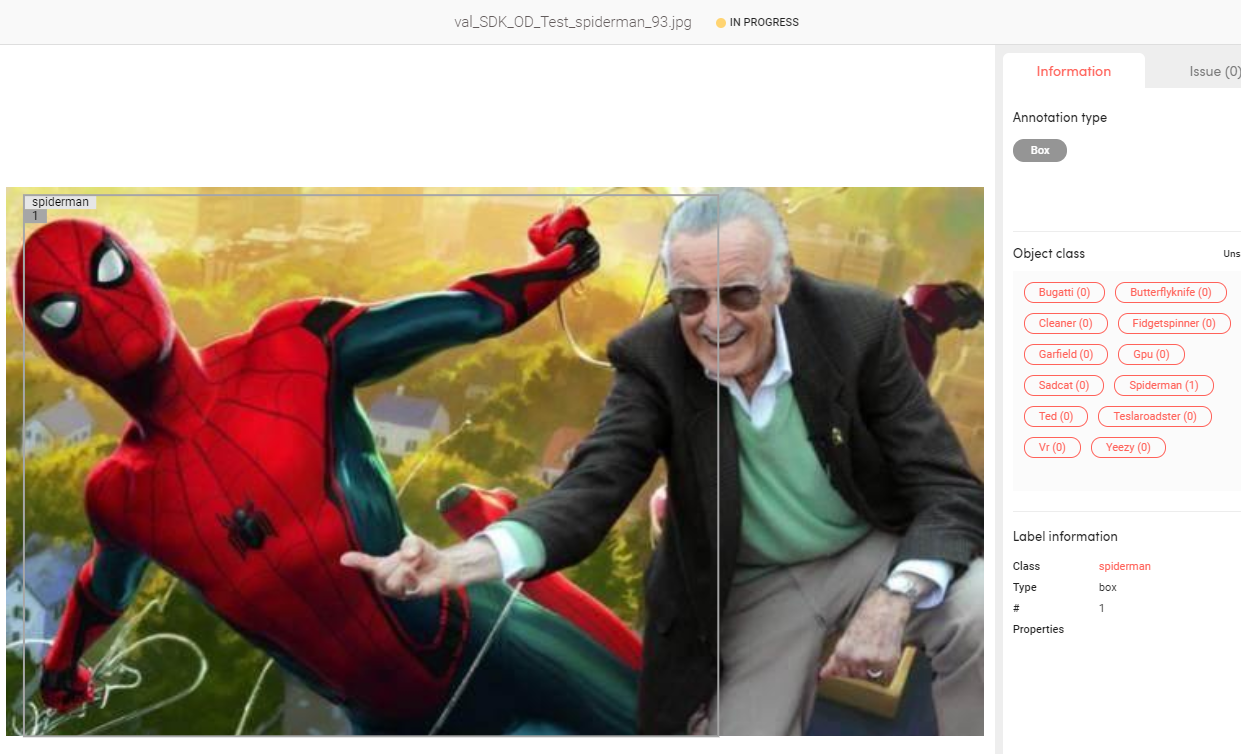

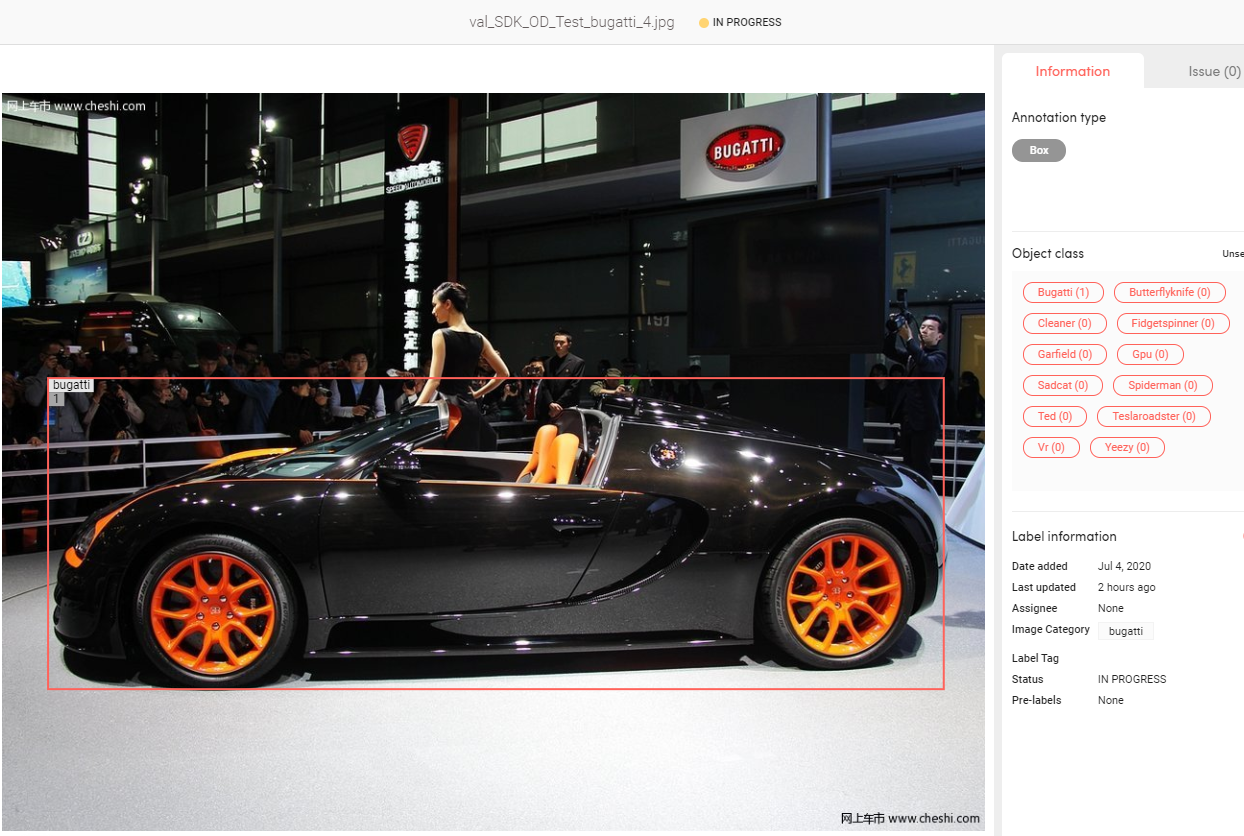

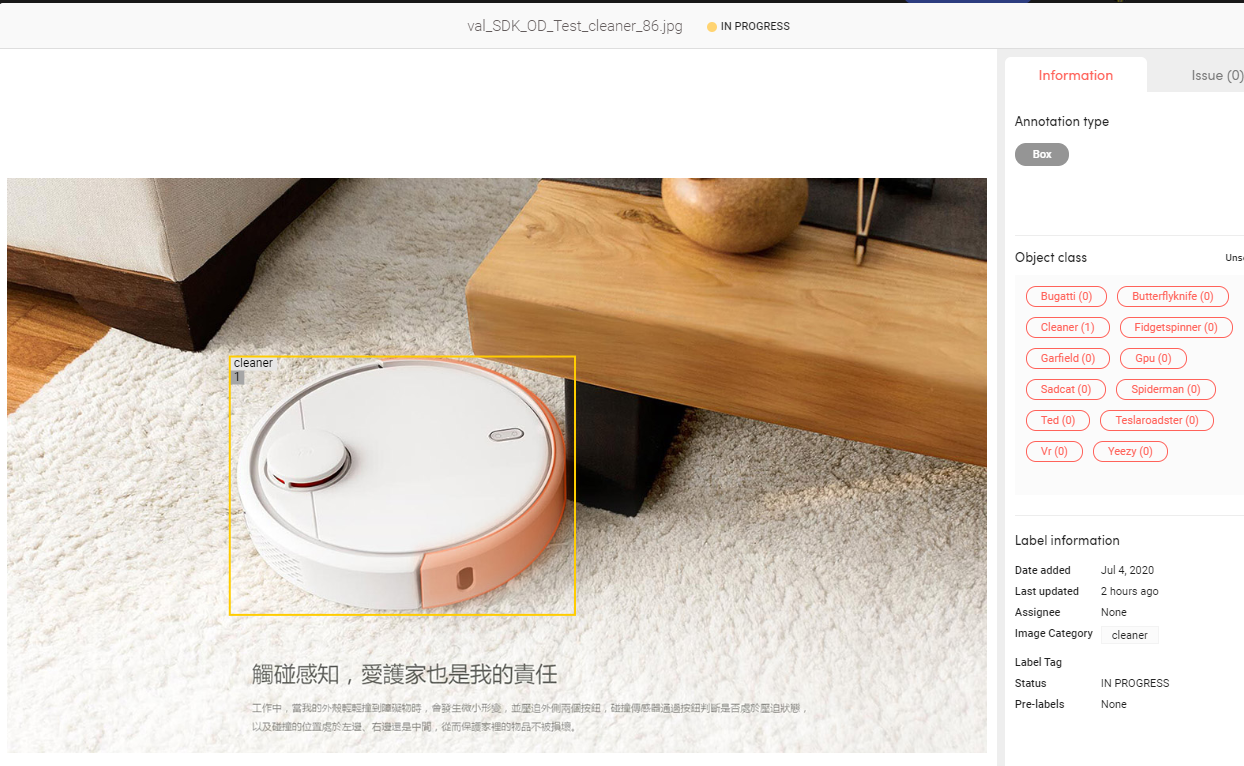